# Measurement Incompatibility Testing

## Test Description

This test runs a single-qubit bell that requires superposition states and incompatible measurments. Alice and Bob Perform the protocol:

1. Alice receives an input $x \in \{0,1,2,3\}$ and encodes it into the BB84 qubit states $|\psi_x\rangle \in \{|0\rangle, |1\rangle, |+\rangle, |-\rangle \}$.
2. Bob Measures the states using two incompatible binary projective measurements conditioned on $y\in\{0,1\}$.
3. Bob outputs the binary measurement result $b\in\{0,1\}$

<img src="img/qubit_bell_violation.png" alt="Drawing" style="width: 400px;"/>

The classical bound in this scenario is

$$
6 \geq \Big(p(0|00) + p(1|10) + p(0|20) + p(1|30)\Big) + \Big(p(1|01) + p(0|11) + p(0|21) + p(1|31)\Big).
$$

However, quantum systems can achieve a score of $6.828$.


## Test Setup

The device-independent test is prototyped on a single circuit of a quantum computer. To reduce the test runtime, Alice's inputs are parallelized over 4 independent qubit registers. Parallelizing the circuits will not skew the test results under the assumption that the IBM quantum computer executes its commands faithfully. 

In [10]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq.managed import IBMQJobManager

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import matplotlib.pyplot as plt
import numpy as np

# custom code
import context
from device_independent_test import incompatible_measurement
from device_independent_test.quantum_communicator import LocalDispatcher

ibmqfactory.load_account:WARNING:2020-07-01 10:19:41,668: Credentials are already in use. The existing account in the session will be replaced.


## Test Circuit

### State Preparation

Alice prepares the BB84 states.

In [2]:
bb84_states = incompatible_measurement.bb84_states()
bb84_states.draw()

q_0: ──────────
     ┌───┐     
q_1: ┤ X ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘

### Incompatible Measurements

Incompatible measurements are constructed by applying rotations before measurements in the computational basis. In the protocol, the measurement bases are conditioned off the input $y$. Therefore, we collect data from two circuits running on the quantum computer, one for $y=0$ and the other for $y=1$.

In [3]:
# Bob's measurement circuit
# measure in either pi/4 or 3pi/4 basis
def measure_circuit(y):
    qc = QuantumCircuit(4)
    theta = -1.0*(np.pi/4 + 0.5*y*np.pi)
    qc.u3(theta,0,0,range(0,4))
    qc.measure_all()
    
    return qc

qc_y0 = bb84_states + measure_circuit(0)

qc_y0.draw()

┌───────────────┐                                   ░ ┌─┐         
   q_0: ┤ U3(-pi/4,0,0) ├───────────────────────────────────░─┤M├─────────
        └─────┬───┬─────┘┌───────────────┐                  ░ └╥┘┌─┐      
   q_1: ──────┤ X ├──────┤ U3(-pi/4,0,0) ├──────────────────░──╫─┤M├──────
              ├───┤      ├───────────────┤                  ░  ║ └╥┘┌─┐   
   q_2: ──────┤ H ├──────┤ U3(-pi/4,0,0) ├──────────────────░──╫──╫─┤M├───
              ├───┤      └─────┬───┬─────┘┌───────────────┐ ░  ║  ║ └╥┘┌─┐
   q_3: ──────┤ X ├────────────┤ H ├──────┤ U3(-pi/4,0,0) ├─░──╫──╫──╫─┤M├
              └───┘            └───┘      └───────────────┘ ░  ║  ║  ║ └╥┘
meas_0: ═══════════════════════════════════════════════════════╩══╬══╬══╬═
                                                                  ║  ║  ║ 
meas_1: ══════════════════════════════════════════════════════════╩══╬══╬═
                                                                     ║  ║ 
meas_2: ═════════════════════════════════════════════════════════════╩══╬═
                                                                        ║ 
meas_3: ════════════════════════════════════════════════════════════════╩═

In [4]:
# y = 1
qc_y1 = bb84_states + measure_circuit(1)

qc_y1.draw()

┌────────────────┐                                     ░ ┌─┐         
   q_0: ┤ U3(-3pi/4,0,0) ├─────────────────────────────────────░─┤M├─────────
        └─────┬───┬──────┘┌────────────────┐                   ░ └╥┘┌─┐      
   q_1: ──────┤ X ├───────┤ U3(-3pi/4,0,0) ├───────────────────░──╫─┤M├──────
              ├───┤       ├────────────────┤                   ░  ║ └╥┘┌─┐   
   q_2: ──────┤ H ├───────┤ U3(-3pi/4,0,0) ├───────────────────░──╫──╫─┤M├───
              ├───┤       └─────┬───┬──────┘┌────────────────┐ ░  ║  ║ └╥┘┌─┐
   q_3: ──────┤ X ├─────────────┤ H ├───────┤ U3(-3pi/4,0,0) ├─░──╫──╫──╫─┤M├
              └───┘             └───┘       └────────────────┘ ░  ║  ║  ║ └╥┘
meas_0: ══════════════════════════════════════════════════════════╩══╬══╬══╬═
                                                                     ║  ║  ║ 
meas_1: ═════════════════════════════════════════════════════════════╩══╬══╬═
                                                                        ║  ║ 
meas_2: ════════════════════════════════════════════════════════════════╩══╬═
                                                                           ║ 
meas_3: ═══════════════════════════════════════════════════════════════════╩═

## Running on the Simulator

The following code block uses our dispatcher to batch run the prepare and measure circuits on the Qiskit simulator. 

In [5]:
dispatcher = LocalDispatcher([provider.get_backend('ibmq_qasm_simulator')])
shots = 1000

counts = dispatcher.batch_run_and_transmit(
    [incompatible_measurement.bb84_states()],
    [[QuantumCircuit(4)],[measure_circuit(0),measure_circuit(1)]],
    shots
)

### Outcome Statistics

The outcome statistics for each test are displayed.


#### Statistics for y = 0

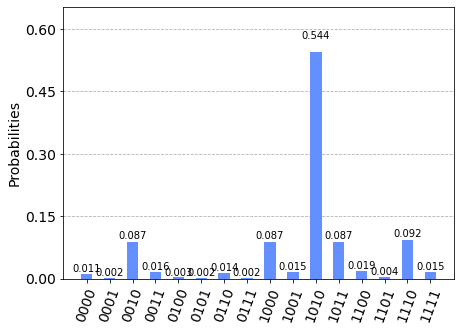

In [6]:
plot_histogram(counts[0])

#### Statistics for y = 1

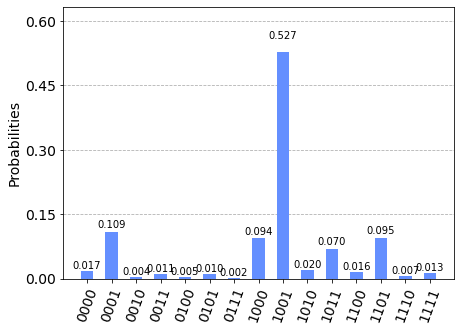

In [7]:
plot_histogram(counts[1])

### Verifying Bell Violation

The outcome statistics can be used to compute the score against the bell inequality. The classical bound is 6, but our quantum protocol can achieve a score of 6.828.

In [8]:
bell_violation = incompatible_measurement.bell_violation(counts[0], counts[1], shots, shots)

print("classical bound : ", 6)
print("bell violation : ", bell_violation)

classical bound :  6
bell violation :  6.83


## Running the Test on a Quantum Computer

We use the handshake class to run the device-independent for our handshake protocol. The test is run on the `'ibmq_16_melbourne'` quantum computer. 

In [9]:
from device_independent_test.handshake import HandShake

dispatcher = LocalDispatcher([provider.get_backend('ibmq_16_melbourne')])
handshake = HandShake(dispatcher)

shots = 2000
tolerance = 0.4
handshake.measurement_incompatibility(tolerance, shots)

Passed Measurment Incompatibility with value:  6.558


(True, 6.558)

The quantum computer violates the classical bound of 6, but does not achieve the optimal quantum score, 6.828. This is likely due to noise inherent in running the quantum computer. In bipartite communication scenarios, the allowable amount of error, will have to be tailored for the protocols which will run once our verification handshake is complete.  